In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import unyt
import swiftsimio as sw
from swiftgalaxy import SWIFTGalaxy, SOAP
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation import generate_smoothing_lengths
from scipy.spatial.transform import Rotation

In [ ]:
# Good galaxy imaging options (in the L25m5 run)
# ID 479 at z=0 (snap 123)
#       Very nice spiral-looking thing
#
# ID 16240 at z=0.5 (snap 98)
#       Sensible spiral, maybe some issues with the rotation
#
# ID 160708 at z=1 (snap 88)
#       Problem galaxy, doesn't rotate to face-on well

In [4]:
colibre_base_path = "/mnt/su3-pro/colibre/"
simulation_dir = "L0025N0752/THERMAL_AGN"

soap_path_z05 = "SOAP/halo_properties_0098.hdf5"
soap_catalogue_file_z05 = os.path.join(colibre_base_path, simulation_dir, soap_path_z05)
virtual_snapshot_path_z05 = "SOAP/colibre_with_SOAP_membership_0098.hdf5"
virtual_snapshot_file_z05 = os.path.join(colibre_base_path, simulation_dir, virtual_snapshot_path_z05)

ID_z05 = 16240


sg05 = SWIFTGalaxy(
    virtual_snapshot_file_z05,
    SOAP(
        soap_catalogue_file_z05,
        soap_index=ID_z05
    ),
)

Lstars = sg05.halo_catalogue.exclusive_sphere_30kpc.angular_momentum_stars.squeeze() #10kpc, 30kpc?
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    unyt.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat))
sg05.rotate(Rotation.from_matrix(rotmat)) # hopefully this puts the galaxy face-on

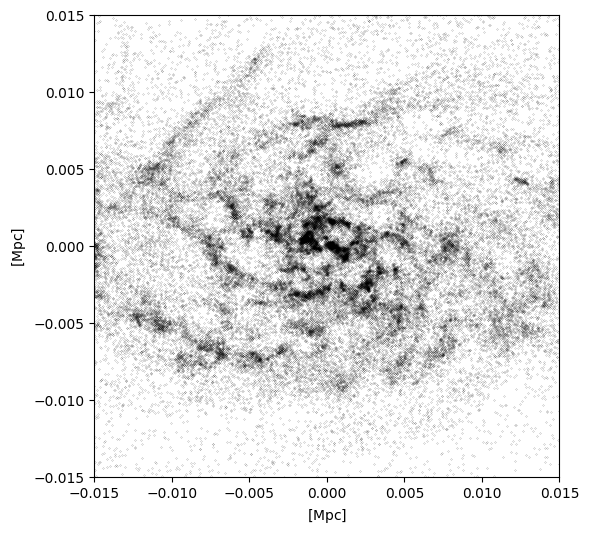

In [5]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0], sg05.gas.coordinates[:,1],c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

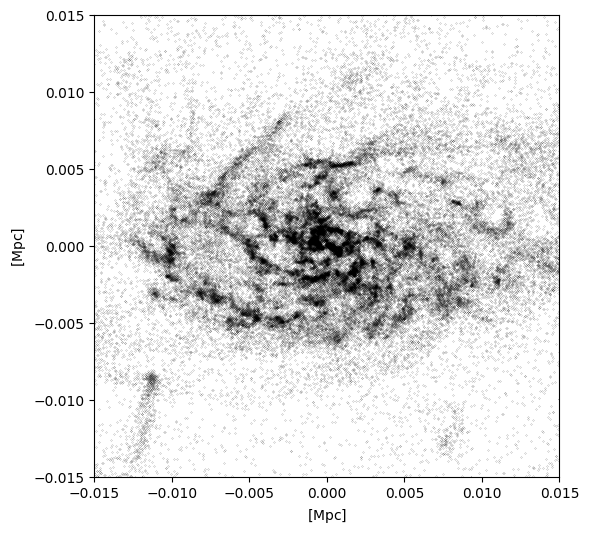

In [6]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0].to_physical(), sg05.gas.coordinates[:,1].to_physical(),c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

In [23]:
disc_radius = 15.0*unyt.kpc
disc_radius_c = 15.0*unyt.kpc / sg05.metadata.a

disc_region = sw.objects.cosmo_array(
        [-1*disc_radius, disc_radius, -1*disc_radius, disc_radius],
        comoving=False,
        scale_factor=sg05.metadata.a,
        scale_exponent=1,
)

disc_region_c = sw.objects.cosmo_array(
        [-1*disc_radius_c, disc_radius_c, -1*disc_radius_c, disc_radius_c],
        comoving=True,
        scale_factor=sg05.metadata.a,
        scale_exponent=1,
)

In [24]:
print(disc_region)
print(disc_region_c)

[-15.  15. -15.  15.] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


In [25]:
gas_map = project_gas(
        sg05,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

gas_map_c = project_gas(
        sg05,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region_c,
)

In [26]:
print(disc_region)
print(disc_region_c)

[-22.5  22.5 -22.5  22.5] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


In [27]:
star_map = project_pixel_grid(
        data=sg05.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

star_map_c = project_pixel_grid(
        data=sg05.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region_c,
)

In [28]:
print(disc_region)
print(disc_region_c)

[-33.75  33.75 -33.75  33.75] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


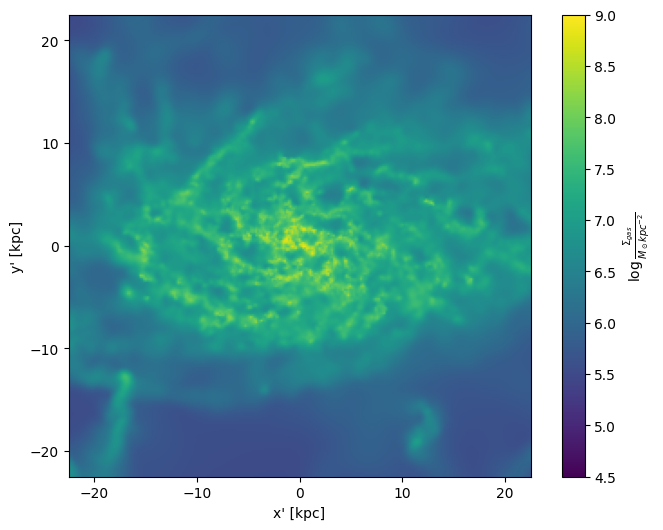

In [29]:
gmin = 4.5
gmax = 9

fig,ax = plt.subplots(1,1,figsize=(8,6))
mp = ax.imshow(
    np.log10(gas_map_c.to_value(unyt.solMass / unyt.kpc**2).T),
    cmap="viridis",
    extent=disc_region_c,
    origin="lower",
    vmin=gmin,
    vmax=gmax,
)
ax.set_xlabel(f"x' [{disc_radius.units}]")
ax.set_ylabel(f"y' [{disc_radius.units}]")
cb = fig.colorbar(mp, ax=ax,label=r'$\log \frac{\Sigma_{gas}}{M_\odot kpc^{-2}}$')